In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'validation':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', data_transforms['train']),
    'validation':
        datasets.ImageFolder('data/validation', data_transforms['validation'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=32,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=32,
            shuffle=False,
            num_workers=4)}

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False
 
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [14]:
torch.cuda.is_available()

False

In [5]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
 
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model
 
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.4902, acc: 0.7536
validation loss: 0.3011, acc: 0.9200
Epoch 2/3
----------
train loss: 0.2524, acc: 0.9150
validation loss: 0.2850, acc: 0.8800
Epoch 3/3
----------
train loss: 0.2455, acc: 0.9006
validation loss: 0.2193, acc: 0.9150


In [6]:
#saving the model
#torch.save(model_trained.state_dict(),'models/pytorch/weights.h5')

In [7]:
# loading the model
# model = models.resnet50(pretrained=False).to(device)
# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128, 2)).to(device)
# model.load_state_dict(torch.load('models/pytorch/weights.h5'))

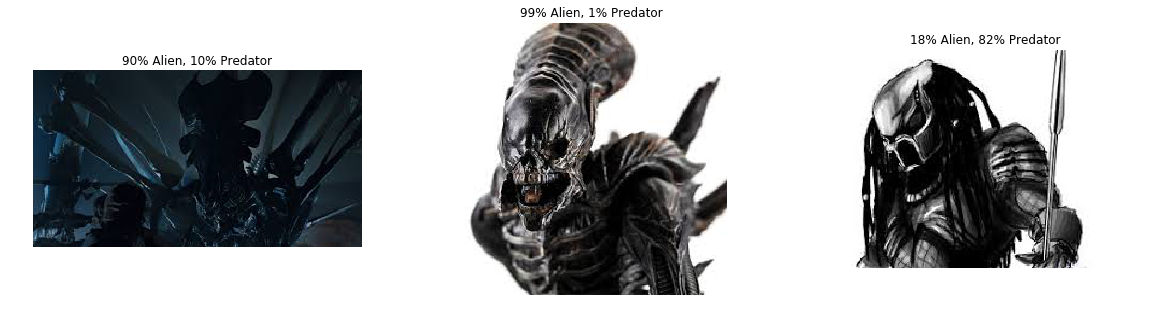

In [8]:
validation_img_paths = ["data/validation/alien/7.jpg",
                        "data/validation/alien/25.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])
 
pred_logits_tensor = model_trained(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)
    